# Multi-task learning TensorFlow with the Head API

This notebook is a companion to the following blog post: 
https://iaml.it/blog/multitask-learning-tensorflow/

## Prerequisites

In [1]:
# Install all necessary packages
!pip install tensorflow tqdm requests --upgrade

    100% |████████████████████████████████| 48.0MB 29kB/s 
    100% |████████████████████████████████| 51kB 10.9MB/s 
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: astor>=0.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: six>=1.10.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: absl-py>=0.1.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
    100% |████████████████████████████████| 7.7MB 182kB/s 
Requirement already up-to-date: termcolor>=1.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
    100% |████████████████████████████████| 3.1MB 441kB/s 
    100% |████████████████████████████████| 51kB 11.1MB/s 
    100% |████████████████████████████████| 6.4MB 207kB/s 
Requirement already up-to-date: gast>=0.2.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: nu

  Found existing installation: tensorflow 1.6.0
    Uninstalling tensorflow-1.6.0:
      Successfully uninstalled tensorflow-1.6.0


## Data download

In [2]:
# Dataset is taken from here: http://mmlab.ie.cuhk.edu.hk/projects/TCDCN.html
# Small code is taken from this StackOverflow thread: https://stackoverflow.com/questions/22676/how-do-i-download-a-file-over-http-using-python
# This could take a while!

from tqdm import tqdm
import requests

url = "http://mmlab.ie.cuhk.edu.hk/projects/TCDCN/data/MTFL.zip"
response = requests.get(url, stream=True)

with open("MTFL", "wb") as handle:
    for data in tqdm(response.iter_content(), unit=' KB'):
        handle.write(data)

150152960 KB [25:41, 97417.50 KB/s]


In [0]:
# Unzip all files
import zipfile
zip_ref = zipfile.ZipFile('MTFL', 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
!ls

AFLW  datalab  lfw_5590  MTFL  net_7876  readme.txt  testing.txt  training.txt


## Data loading in Pandas

In [0]:
# Import dataset in Pandas
import pandas as pd
train_data = pd.read_csv('training.txt', sep=' ', header=None, skipinitialspace=True, nrows=10000)
test_data = pd.read_csv('testing.txt', sep=' ', header=None, skipinitialspace=True, nrows=2995)

In [7]:
train_data.iloc[0]

0     lfw_5590\Aaron_Eckhart_0001.jpg
1                              107.25
2                              147.75
3                              126.25
4                              106.25
5                              140.75
6                              108.75
7                              113.25
8                              143.75
9                              158.75
10                             162.75
11                                  1
12                                  2
13                                  2
14                                  3
Name: 0, dtype: object

In [0]:
train_data.iloc[:, 0] = train_data.iloc[:, 0].apply(lambda s: s.replace('\\', '/')) # Needed for filename convention
test_data.iloc[:, 0] = test_data.iloc[:, 0].apply(lambda s: s.replace('\\', '/')) # Needed for filename convention

In [0]:
from sklearn import preprocessing
train_data.iloc[:, 1:11] = preprocessing.MinMaxScaler().fit_transform(train_data.iloc[:, 1:11])
test_data.iloc[:, 1:11] = preprocessing.MinMaxScaler().fit_transform(test_data.iloc[:, 1:11])

## Data loading with tf.data

In [0]:
import numpy as np
import tensorflow as tf

In [23]:
# Example code for handling datasets

filenames = tf.constant(train_data.iloc[:, 0].tolist())
labels = tf.constant(train_data.iloc[:, 1:].values)

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

it = dataset.batch(64).make_one_shot_iterator().get_next()

with tf.Session() as sess:
  (imgs, labels) = sess.run(it)
  print(imgs[0])

b'lfw_5590/Aaron_Eckhart_0001.jpg'


In [0]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename, label):
  image_string = tf.read_file(filename) 
  image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
  image_resized = tf.image.resize_images(image_decoded, [40, 40])
  return {"x": image_resized}, label

In [0]:
# This snippet is adapted from here: https://www.tensorflow.org/programmers_guide/datasets

def input_fn(data, is_eval=False):

  # Path delle immagini
  filenames = tf.constant(data.iloc[:, 0].tolist())

  # Etichette delle immagini
  labels = tf.constant(data.iloc[:, 1:].values.astype(np.float32))

  # Costruisco il dataset
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(_parse_function)

  # Logica di training / testing
  if is_eval:
    dataset = dataset.batch(64)
  else:
    dataset = dataset.repeat().shuffle(1000).batch(64)
    
  # Costruisco l'iteratore
  return dataset.make_one_shot_iterator().get_next()
  
  #for (filename, label) in tfe.Iterator(dataset):
  #  d = _parse_function(filename, label)

[0.33482143 0.32603687 0.3471564  0.3612805  0.2852697  0.4357639
 0.47532895 0.41169155 0.35       0.36334747 1.         2.
 2.         3.        ]


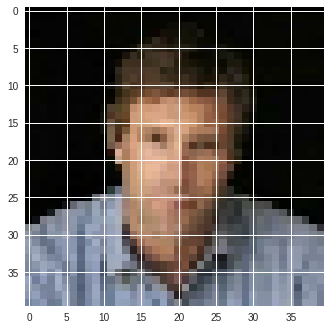

In [63]:
import matplotlib.pyplot as plt
with tf.Session() as sess:
  (imgs, labels) = sess.run(input_fn(train_data, True))
  plt.imshow(imgs["x"][0] / 255)
  print(labels[0])

## Standard classical estimator (single-task only!)

In [0]:
def extract_features(features):
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 40, 40, 3])

  # Primo layer convolutivo
  conv1 = tf.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Secondo layer convolutivo
  conv2 = tf.layers.conv2d(inputs=pool1, filters=48, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Terzo layer convolutivo
  conv3 = tf.layers.conv2d(inputs=pool2, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
  pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
  
  # Quarto layer convolutivo
  conv4 = tf.layers.conv2d(inputs=pool3, filters=64, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)
  
  # Dense Layer
  flat = tf.reshape(conv4, [-1, 5 * 5 * 64])
  dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
  
  return dense

In [0]:
# Adapted from here: https://www.tensorflow.org/tutorials/layers

def single_task_cnn_model_fn(features, labels, mode):
  
  dense = extract_features(features)
  
  # Predizioni
  predictions = tf.layers.dense(inputs=dense, units=2)

  outputs = {
      "predictions": predictions
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=outputs)

  # Funzione costo (errore quadratico medio)
  loss = tf.losses.mean_squared_error(labels=labels[:, 0:2], predictions=predictions)

  # Ottimizzazione
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Valutazione del modello
  eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(
          labels=labels[:, 0:2], predictions=outputs["predictions"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [66]:
# Create the Estimator
single_task_classifier = tf.estimator.Estimator(
    model_fn=single_task_cnn_model_fn, model_dir="/tmp/cnn_singletask")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/cnn_singletask', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fadfb0a98d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [67]:
# Train the model
single_task_classifier.train(input_fn=lambda: input_fn(train_data), steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/cnn_singletask/model.ckpt.
INFO:tensorflow:loss = 556.0696, step = 1
INFO:tensorflow:global_step/sec: 3.19897
INFO:tensorflow:loss = 0.07555919, step = 101 (31.262 sec)
INFO:tensorflow:global_step/sec: 3.38642
INFO:tensorflow:loss = 0.024925504, step = 201 (29.530 sec)
INFO:tensorflow:global_step/sec: 3.23989
INFO:tensorflow:loss = 0.04867403, step = 301 (30.866 sec)
INFO:tensorflow:global_step/sec: 3.28112
INFO:tensorflow:loss = 0.03839631, step = 401 (30.480 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/cnn_singletask/model.ckpt.
INFO:tensorflow:Loss for final step: 0.010943847.


In [69]:
single_task_classifier.evaluate(input_fn=lambda: input_fn(test_data, is_eval=True))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-10-09:58:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_singletask/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-10-09:58:53
INFO:tensorflow:Saving dict for global step 500: global_step = 500, loss = 0.08994147, rmse = 0.2998508


{'global_step': 500, 'loss': 0.08994147, 'rmse': 0.2998508}

In [0]:
# Funzione di input per predizioni (hack, si potrebbe migliorare!)
def input_fn_predict(data):

  # Path delle immagini
  filenames = tf.constant(data.iloc[:, 0].tolist())

  # Etichette delle immagini
  labels = tf.constant(data.iloc[:, 1:].values)

  # Costruisco il dataset
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(_parse_function)
  dataset = dataset.batch(64)
    
  # Costruisco l'iteratore
  f, l = dataset.make_one_shot_iterator().get_next()
  return f
  
  #for (filename, label) in tfe.Iterator(dataset):
  #  d = _parse_function(filename, label)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_singletask/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


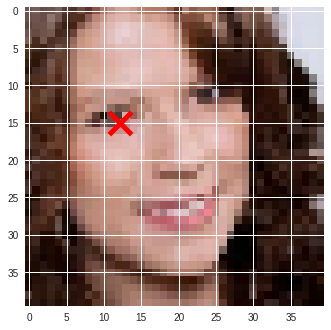

In [80]:
# Valutiamo una singola predizione
p = list(single_task_classifier.predict(lambda: input_fn_predict(test_data)))

with tf.Session() as sess:
  imgs = sess.run(input_fn_predict(test_data))
  plt.imshow(imgs["x"][1] / 255)
  plt.scatter(p[1]['predictions'][0] * 40, p[1]['predictions'][1] * 40, 500, marker='x', color='red', linewidth=5)

## Simplify the code with the Head API

In [0]:
# Check the code here: https://www.tensorflow.org/api_docs/python/tf/contrib/estimator/regression_head

def single_head_cnn_model_fn(features, labels, mode):
  
  dense = extract_features(features)
  
  # Predizioni
  predictions = tf.layers.dense(inputs=dense, units=2)

  # Ottimizzatore
  optimizer = tf.train.AdamOptimizer()
  
  # Modello finale
  regression_head = tf.contrib.estimator.regression_head(label_dimension=2)
  return regression_head.create_estimator_spec(features, mode, predictions, labels[:, 0:2], lambda x: optimizer.minimize(x, global_step = tf.train.get_or_create_global_step()))

In [82]:
# Create the Estimator
cnn_classifier = tf.estimator.Estimator(
    model_fn=single_head_cnn_model_fn, model_dir="/tmp/cnn_single_head")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/cnn_single_head', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fae002b7dd8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [83]:
# Train the model
cnn_classifier.train(input_fn=lambda: input_fn(train_data), steps=100)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/cnn_single_head/model.ckpt.
INFO:tensorflow:loss = 19280.736, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /tmp/cnn_single_head/model.ckpt.
INFO:tensorflow:Loss for final step: 14.961566.


## Multi-task learning with the Head API

In [0]:
def multihead_input_fn(data, is_eval=True):
  features, labels = input_fn(data, is_eval=is_eval)
  return features, {'head_eye': labels[:, 0:2], 'head_pose': tf.cast(labels[:, -1] - 1.0, tf.int32)}

In [0]:
def multi_head_cnn_model_fn(features, labels, mode):
  
  dense = extract_features(features)
  
  # Predizioni della rete (per ciascun task)
  predictions_eye = tf.layers.dense(inputs=dense, units=2)
  predictions_pose = tf.layers.dense(inputs=dense, units=5)
  logits = {'head_eye': predictions_eye, 'head_pose': predictions_pose}
  
  # Ottimizzatore
  optimizer = tf.train.AdamOptimizer()
  
  # Definiamo le due head
  regression_head = tf.contrib.estimator.regression_head(name='head_eye', label_dimension=2)
  classification_head = tf.contrib.estimator.multi_class_head(name='head_pose', n_classes=5)
  
  multi_head = tf.contrib.estimator.multi_head([regression_head, classification_head])
  
  return multi_head.create_estimator_spec(features, mode, logits, labels, lambda x: optimizer.minimize(x, global_step = tf.train.get_or_create_global_step()))

In [96]:
# Create the Estimator
multitask_classifier = tf.estimator.Estimator(
    model_fn=multi_head_cnn_model_fn, model_dir="/tmp/cnn_multi_head")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/cnn_multi_head', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fadea4fd860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [97]:
# Train the model
multitask_classifier.train(input_fn=lambda: multihead_input_fn(train_data), steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/cnn_multi_head/model.ckpt.
INFO:tensorflow:loss = 66775.99, step = 1
INFO:tensorflow:global_step/sec: 3.23734
INFO:tensorflow:loss = 66.12974, step = 101 (30.897 sec)
INFO:tensorflow:Saving checkpoints for 157 into /tmp/cnn_multi_head/model.ckpt.
INFO:tensorflow:Loss for final step: 31.080082.


In [98]:
multitask_classifier.evaluate(input_fn=lambda: multihead_input_fn(test_data, is_eval=True))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-10-10:27:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_multi_head/model.ckpt-157
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-10-10:27:36
INFO:tensorflow:Saving dict for global step 157: accuracy/head_pose = 0.36227044, average_loss/head_eye = 0.4777564, average_loss/head_pose = 1.4020722, global_step = 157, loss = 150.23335, loss/head_eye = 60.88853, loss/head_pose = 89.34481


{'accuracy/head_pose': 0.36227044,
 'average_loss/head_eye': 0.4777564,
 'average_loss/head_pose': 1.4020722,
 'global_step': 157,
 'loss': 150.23335,
 'loss/head_eye': 60.88853,
 'loss/head_pose': 89.34481}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_multi_head/model.ckpt-157
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


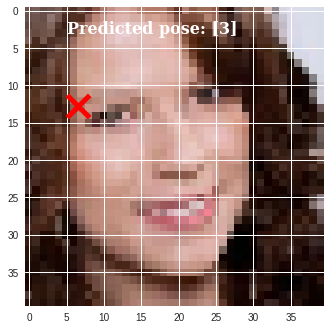

In [126]:
# Valutiamo una singola predizione
p = list(multitask_classifier.predict(lambda: input_fn_predict(test_data)))

with tf.Session() as sess:
  imgs = sess.run(input_fn_predict(test_data))
  
  font = {'family': 'serif',
        'color':  'white',
        'weight': 'bold',
        'size': 16,
        }

  
  img_idx = 1

  prediction_eye = p[img_idx][(('head_eye', 'predictions'))]
  prediction_pose = p[img_idx][(('head_pose', 'class_ids'))]
  
  plt.imshow(imgs["x"][img_idx] / 255)
  plt.scatter(prediction_eye[0] * 40, prediction_eye[1] * 40, 500, marker='x', color='red', linewidth=5)
  plt.text(5, 3, 'Predicted pose: {}'.format(prediction_pose), fontdict=font)

Text(5,3,'Predicted pose: [3]')

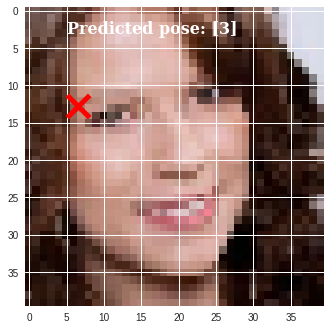

In [125]:
  font = {'family': 'serif',
        'color':  'white',
        'weight': 'bold',
        'size': 16,
        }

  
  img_idx = 1

  prediction_eye = p[img_idx][(('head_eye', 'predictions'))]
  prediction_pose = p[img_idx][(('head_pose', 'class_ids'))]
  
  plt.imshow(imgs["x"][img_idx] / 255)
  plt.scatter(prediction_eye[0] * 40, prediction_eye[1] * 40, 500, marker='x', color='red', linewidth=5)
  plt.text(5, 3, 'Predicted pose: {}'.format(prediction_pose), fontdict=font)